<a href="https://colab.research.google.com/github/KIRTIRAJ4327/30days-AI-challenge/blob/main/day2_personal_expense_categorizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#**Simple Personal Expense Categorizer**

# Day 2 of the 30-Day AI Mini-Projects Challenge

**Set Up Your Environment**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import re
# Set up visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)

# Step 1: Load and examine the **data**

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Generate dates for 6 months of transactions
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 6, 30)
dates = [start_date + timedelta(days=x) for x in range((end_date-start_date).days)]

# Common merchants by category
merchants = {
    "Groceries": ["Walmart", "Kroger", "Trader Joe's", "Whole Foods", "Safeway", "Aldi"],
    "Dining": ["McDonald's", "Starbucks", "Chipotle", "Pizza Hut", "Local Cafe", "Restaurant"],
    "Transportation": ["Uber", "Lyft", "Shell", "Chevron", "BP Gas", "Transit Authority"],
    "Shopping": ["Amazon", "Target", "Best Buy", "Macy's", "Nike", "HomeGoods"],
    "Entertainment": ["Netflix", "Spotify", "AMC Movies", "Hulu", "Disney+", "Concert Tickets"],
    "Utilities": ["Electric Company", "Water Service", "Internet Provider", "Phone Bill", "Gas Company"],
    "Housing": ["Rent Payment", "Mortgage", "Home Insurance", "HOA Fee", "Property Tax"],
    "Healthcare": ["Pharmacy", "Doctor Visit", "Dental Clinic", "Vision Center", "Health Insurance"]
}

# Generate random transactions
num_transactions = 500
categories = list(merchants.keys())
category_weights = [0.25, 0.2, 0.15, 0.1, 0.1, 0.08, 0.07, 0.05]  # More groceries/dining transactions

transactions = []
for _ in range(num_transactions):
    # Select random date
    date = np.random.choice(dates)

    # Select category and merchant
    category = np.random.choice(categories, p=category_weights)
    merchant = np.random.choice(merchants[category])

    # Generate amount based on category
    if category == "Housing":
        amount = round(np.random.uniform(800, 2500), 2)
    elif category == "Utilities":
        amount = round(np.random.uniform(40, 200), 2)
    elif category == "Groceries":
        amount = round(np.random.uniform(15, 150), 2)
    elif category == "Healthcare":
        amount = round(np.random.uniform(20, 500), 2)
    else:
        amount = round(np.random.uniform(5, 100), 2)

    # Create description
    descriptions = {
        "Groceries": [f"Purchase at {merchant}", f"{merchant} Grocery", f"Groceries {merchant}"],
        "Dining": [f"{merchant} Restaurant", f"Food at {merchant}", f"{merchant} Order"],
        "Transportation": [f"{merchant} Gas", f"Ride with {merchant}", f"{merchant} Travel"],
        "Shopping": [f"{merchant} Purchase", f"Shopping at {merchant}", f"{merchant} Store"],
        "Entertainment": [f"{merchant} Subscription", f"{merchant} Service", f"{merchant} Entertainment"],
        "Utilities": [f"{merchant} Monthly", f"{merchant} Bill", f"{merchant} Payment"],
        "Housing": [f"{merchant}", f"{merchant} Monthly", f"{merchant} Payment"],
        "Healthcare": [f"{merchant} Service", f"{merchant} Visit", f"{merchant} Care"]
    }

    description = np.random.choice(descriptions[category])

    # Add to transactions list
    transactions.append({
        "date": date.strftime("%Y-%m-%d"),
        "description": description,
        "amount": amount,
        "category": category  # True category for training
    })

# Create DataFrame
df = pd.DataFrame(transactions)

# Add some randomness to make it more realistic
for i in range(len(df)):
    if np.random.random() < 0.2:  # 20% chance to add transaction details
        df.loc[i, "description"] += f" #{np.random.randint(1000, 9999)}"

# Save to CSV
df.to_csv("synthetic_financial_data.csv", index=False)
print(f"Created dataset with {len(df)} transactions across {len(categories)} categories")
df.head()

Created dataset with 500 transactions across 8 categories


,date,description,amount,category
0,2023-03-15,Shopping at HomeGoods,9.77,Shopping
1,2023-01-06,Pizza Hut Order,86.61,Dining
2,2023-04-13,Hulu Service,16.83,Entertainment
3,2023-04-21,Chevron Travel,97.43,Transportation
4,2023-06-20,Shell Travel,76.58,Transportation


**Exploratory Data Analysis**

In [ ]:
# Load the generated data
df = pd.read_csv("synthetic_financial_data.csv")

# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nColumn names:", df.columns.tolist())
print("\nFirst 5 transactions:")
print(df.head())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Display category distribution
print("\nCategory distribution:")
print(df['category'].value_counts())

Dataset shape: (500, 4)

Column names: ['date', 'description', 'amount', 'category']

First 5 transactions:
         date            description  amount        category
0  2023-03-15  Shopping at HomeGoods    9.77        Shopping
1  2023-01-06        Pizza Hut Order   86.61          Dining
2  2023-04-13           Hulu Service   16.83   Entertainment
3  2023-04-21         Chevron Travel   97.43  Transportation
4  2023-06-20           Shell Travel   76.58  Transportation

Missing values:
date           0
description    0
amount         0
category       0
dtype: int64

Category distribution:
category
Groceries         109
Dining            101
Transportation     79
Entertainment      57
Shopping           47
Housing            42
Utilities          42
Healthcare         23
Name: count, dtype: int64


**Preprocess the Data**

In [ ]:
# Clean the description text
def clean_description(text):
    # Convert to lowercase
    text = text.lower()
    # Remove transaction numbers and special characters
    text = re.sub(r'#\d+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning to descriptions
df['clean_description'] = df['description'].apply(clean_description)

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Create additional features
df['day_of_week'] = df['date'].dt.day_name()
df['month'] = df['date'].dt.month_name()
df['is_weekend'] = df['date'].dt.dayofweek >= 5

# Categorize amount
def categorize_amount(amount):
    if amount <= 20:
        return 'very_small'
    elif amount <= 50:
        return 'small'
    elif amount <= 100:
        return 'medium'
    elif amount <= 200:
        return 'large'
    else:
        return 'very_large'

df['amount_category'] = df['amount'].apply(categorize_amount)

# Display the processed data
print("\nProcessed data sample:")
print(df[['date', 'description', 'clean_description', 'amount', 'amount_category', 'day_of_week', 'category']].head())


Processed data sample:
        date            description      clean_description  amount  \
0 2023-03-15  Shopping at HomeGoods  shopping at homegoods    9.77   
1 2023-01-06        Pizza Hut Order        pizza hut order   86.61   
2 2023-04-13           Hulu Service           hulu service   16.83   
3 2023-04-21         Chevron Travel         chevron travel   97.43   
4 2023-06-20           Shell Travel           shell travel   76.58   

  amount_category day_of_week        category  
0      very_small   Wednesday        Shopping  
1          medium      Friday          Dining  
2      very_small    Thursday   Entertainment  
3          medium      Friday  Transportation  
4          medium     Tuesday  Transportation  


**Split the Data for Training**

In [ ]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare features for the model
# Text features from descriptions
vectorizer = CountVectorizer(max_features=100, stop_words='english')
X_text = vectorizer.fit_transform(df['clean_description'])
text_feature_names = vectorizer.get_feature_names_out()

# Convert to DataFrame
X_text_df = pd.DataFrame(X_text.toarray(), columns=text_feature_names)

# Other features
# One-hot encode categorical features
day_dummies = pd.get_dummies(df['day_of_week'], prefix='day')
month_dummies = pd.get_dummies(df['month'], prefix='month')
amount_dummies = pd.get_dummies(df['amount_category'], prefix='amount')

# Combine all features
X = pd.concat([X_text_df, day_dummies, month_dummies, amount_dummies], axis=1)
y = df['category']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (350, 93)
Testing data shape: (150, 93)


**Train the Model**

In [ ]:
# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.2%}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Accuracy: 98.67%

Classification Report:
                precision    recall  f1-score   support

        Dining       1.00      1.00      1.00        25
 Entertainment       0.92      1.00      0.96        11
     Groceries       0.97      1.00      0.99        36
    Healthcare       1.00      0.83      0.91         6
       Housing       1.00      1.00      1.00        14
      Shopping       1.00      0.93      0.97        15
Transportation       1.00      1.00      1.00        29
     Utilities       1.00      1.00      1.00        14

      accuracy                           0.99       150
     macro avg       0.99      0.97      0.98       150
  weighted avg       0.99      0.99      0.99       150



**Visualize the Results**

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)

# 1. Spending by category

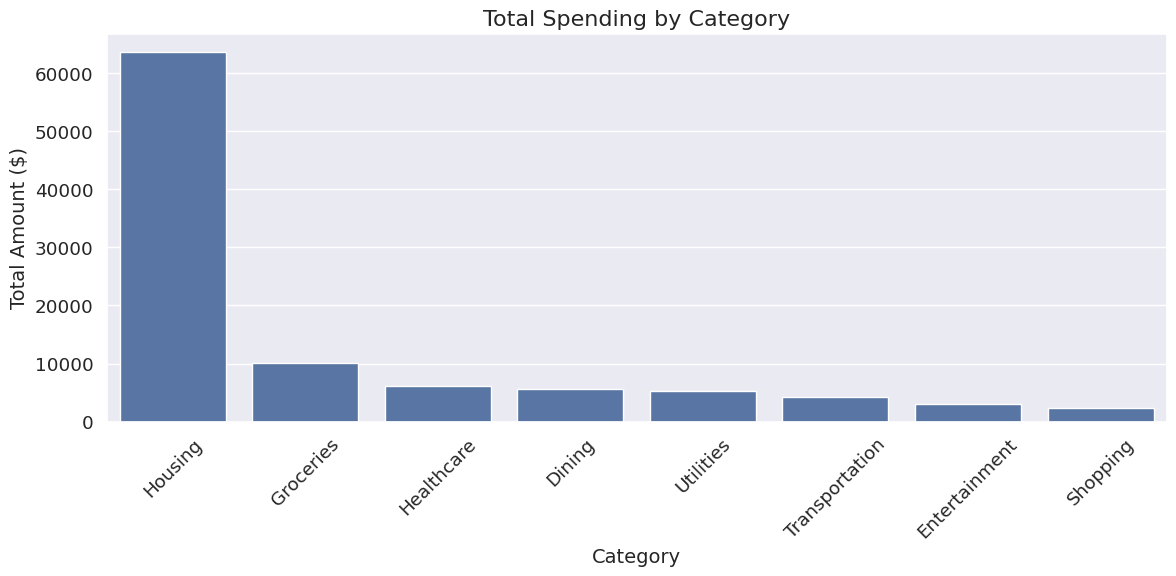

In [ ]:
plt.figure(figsize=(12, 6))
category_spending = df.groupby('category')['amount'].sum().sort_values(ascending=False)
sns.barplot(x=category_spending.index, y=category_spending.values)
plt.title('Total Spending by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Total Amount ($)', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('spending_by_category.png')
plt.show()

# 2. Distribution of transactions by category

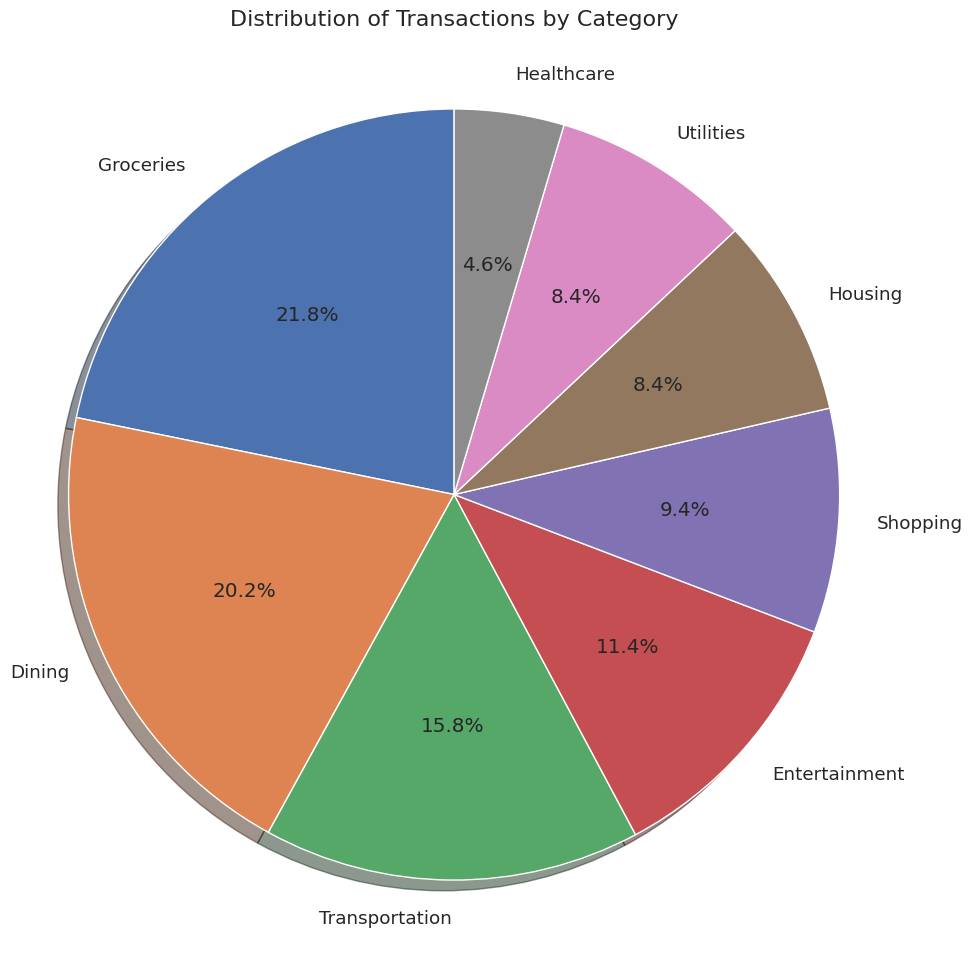

In [ ]:
plt.figure(figsize=(10, 10))
plt.pie(df['category'].value_counts(), labels=df['category'].value_counts().index,
        autopct='%1.1f%%', startangle=90, shadow=True)
plt.title('Distribution of Transactions by Category', fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.savefig('category_distribution.png')
plt.show()

# 3. Monthly spending trends

<Figure size 1400x700 with 0 Axes>

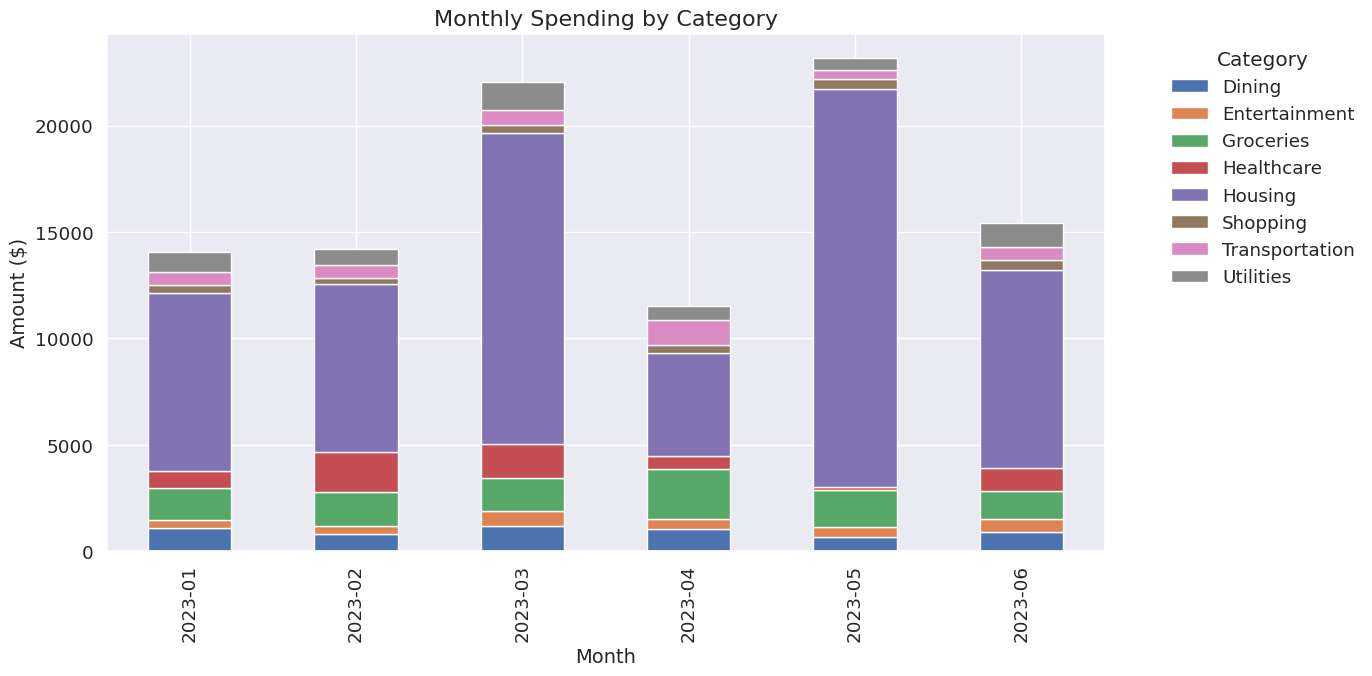

In [ ]:
plt.figure(figsize=(14, 7))
df['month_year'] = df['date'].dt.strftime('%Y-%m')
monthly_spending = df.groupby(['month_year', 'category'])['amount'].sum().unstack()
monthly_spending.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title('Monthly Spending by Category', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Amount ($)', fontsize=14)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('monthly_spending.png')
plt.show()

# 4. Day of week spending patterns

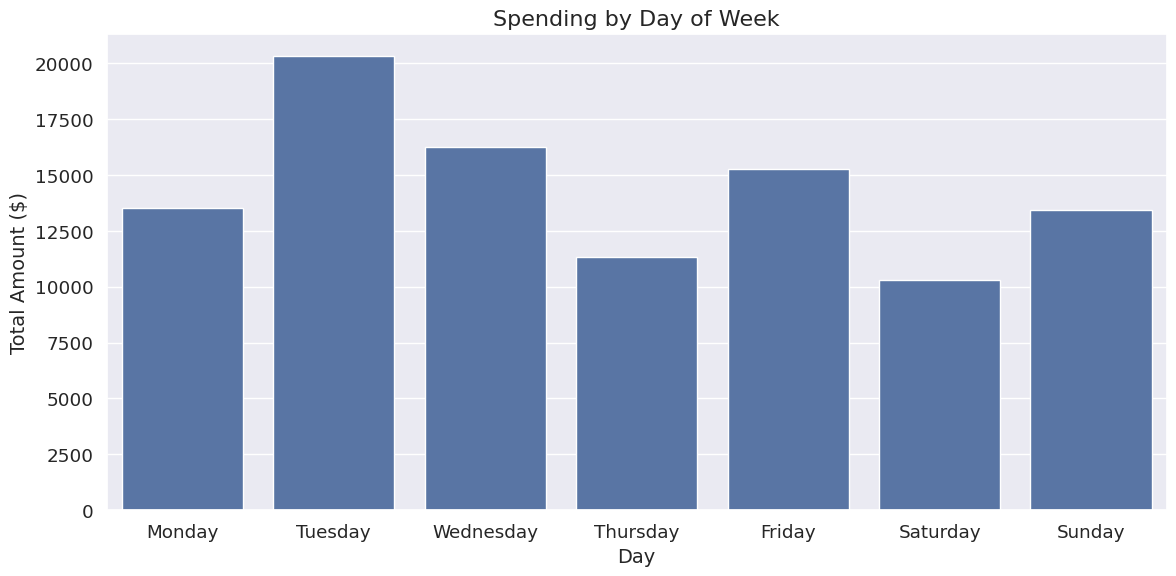

In [ ]:
plt.figure(figsize=(12, 6))
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_spending = df.groupby('day_of_week')['amount'].sum()
day_spending = day_spending.reindex(day_order)
sns.barplot(x=day_spending.index, y=day_spending.values)
plt.title('Spending by Day of Week', fontsize=16)
plt.xlabel('Day', fontsize=14)
plt.ylabel('Total Amount ($)', fontsize=14)
plt.tight_layout()
plt.savefig('day_spending.png')
plt.show()

# 5. Feature importance

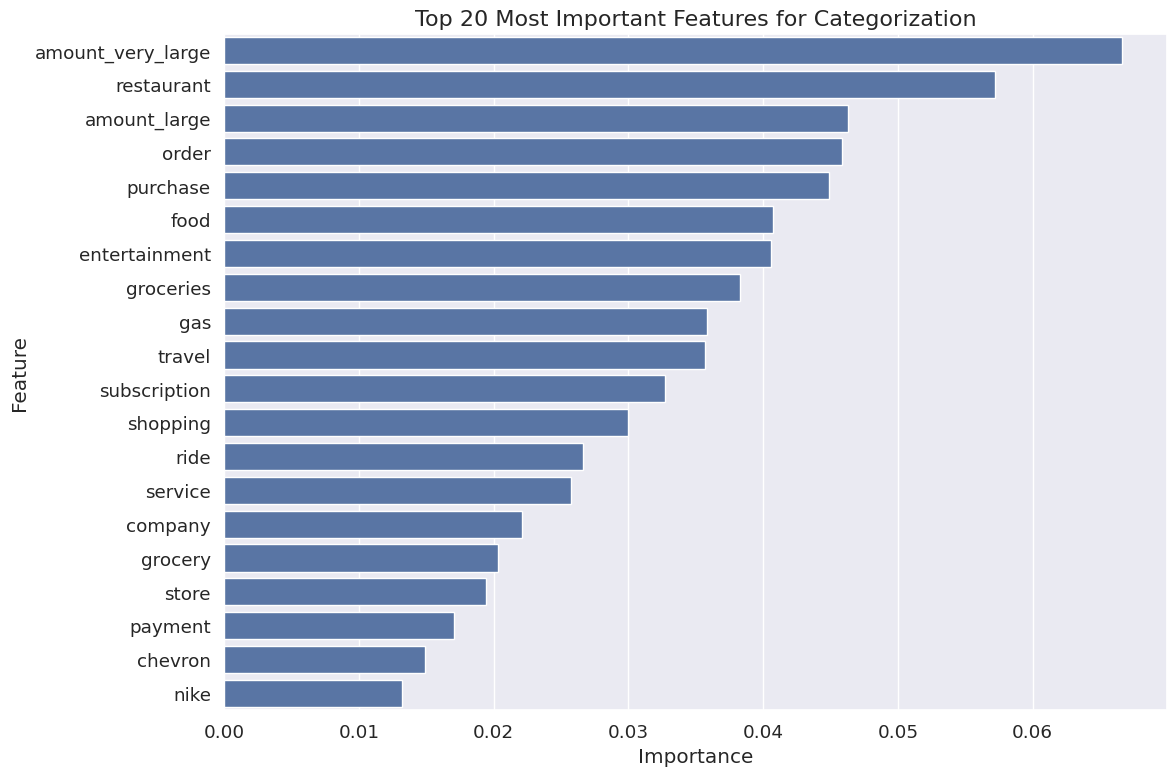

In [ ]:
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
})
top_features = feature_importance.sort_values('Importance', ascending=False).head(20)
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 20 Most Important Features for Categorization', fontsize=16)
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

**Create a Function to Categorize New Transactions**

In [ ]:
def predict_category(description, amount, date):
    """Predict the category of a new transaction"""
    # Clean description
    clean_desc = clean_description(description)

    # Vectorize the description
    desc_vec = vectorizer.transform([clean_desc])
    desc_df = pd.DataFrame(desc_vec.toarray(), columns=vectorizer.get_feature_names_out())

    # Create other features
    # Amount category
    amount_cat = categorize_amount(amount)
    amount_features = pd.DataFrame(columns=[f'amount_{cat}' for cat in df['amount_category'].unique()])
    amount_features.loc[0, f'amount_{amount_cat}'] = 1
    amount_features = amount_features.fillna(0)

    # Day and month
    date_obj = pd.to_datetime(date)
    day = date_obj.day_name()
    month = date_obj.month_name()

    # Day features
    day_features = pd.DataFrame(columns=[f'day_{d}' for d in df['day_of_week'].unique()])
    day_features.loc[0, f'day_{day}'] = 1
    day_features = day_features.fillna(0)

    # Month features
    month_features = pd.DataFrame(columns=[f'month_{m}' for m in df['month'].unique()])
    month_features.loc[0, f'month_{month}'] = 1
    month_features = month_features.fillna(0)

    # Combine all features
    features = pd.concat([desc_df, day_features, month_features, amount_features], axis=1)

    # Ensure all columns from training are present
    for col in X.columns:
        if col not in features.columns:
            features[col] = 0

    # Make sure columns are in the same order as during training
    features = features[X.columns]

    # Make prediction
    prediction = model.predict(features)[0]
    probability = max(model.predict_proba(features)[0])

    return {
        'description': description,
        'predicted_category': prediction,
        'confidence': probability
    }


# Test with a few new transactions

In [ ]:
new_transactions = [
    {'description': 'Walmart Grocery Shopping', 'amount': 78.45, 'date': '2023-07-01'},
    {'description': 'Netflix Monthly Subscription', 'amount': 12.99, 'date': '2023-07-02'},
    {'description': 'Shell Gas Station', 'amount': 45.23, 'date': '2023-07-03'},
    {'description': 'Doctor Visit Copay', 'amount': 25.00, 'date': '2023-07-04'}
]

print("\nPredicting categories for new transactions:")
for txn in new_transactions:
    result = predict_category(txn['description'], txn['amount'], txn['date'])
    print(f"Description: {result['description']}")
    print(f"Predicted Category: {result['predicted_category']}")
    print(f"Confidence: {result['confidence']:.2%}\n")


Predicting categories for new transactions:
Description: Walmart Grocery Shopping
Predicted Category: Shopping
Confidence: 52.00%

Description: Netflix Monthly Subscription
Predicted Category: Entertainment
Confidence: 78.00%

Description: Shell Gas Station
Predicted Category: Transportation
Confidence: 79.00%



<ipython-input-23-a225e4463af4>:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  amount_features = amount_features.fillna(0)
<ipython-input-23-a225e4463af4>:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  day_features = day_features.fillna(0)
<ipython-input-23-a225e4463af4>:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  month_featur

Description: Doctor Visit Copay
Predicted Category: Healthcare
Confidence: 38.00%



**Save the Model for Future Use**

In [ ]:
import pickle

# Create a directory for saving
import os
os.makedirs('expense_categorizer_model', exist_ok=True)

# Save the model
with open('expense_categorizer_model/classifier.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save the vectorizer
with open('expense_categorizer_model/vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

# Save the feature columns
with open('expense_categorizer_model/feature_columns.pkl', 'wb') as f:
    pickle.dump(X.columns.tolist(), f)

print("Model and related components saved successfully!")

Model and related components saved successfully!
